
##Setup

You will need to make a copy of this Colab notebook in your Google Drive before you can edit the homework files. You can do so with **File &rarr; Save a copy in Drive**.


In [ ]:
import os
from google.colab import drive
drive.mount('/content/gdrive')

! ls /content
!ls /content/gdrive/My\ Drive

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
gdrive	omniglot_resized  omniglot_resized.zip	project_data  sample_data
 001.jpg
 45%H2O-CaDPA_400C.avi
 45%H2OCa-DPA_ROOMTemp.avi
'4657091371 (1).py'
'4657091371 - Pankaj Rajak (1).py'
'4657091371 - Pankaj Rajak.py'
 4657091371.py
 acm_mac_2016_word_template.zip
 Adsorp_dataset_and_descriptors.xlsx.gsheet
 AIHW4_19thnov.zip
 AIHW4.-20thNov.zip
 AIHW4.zip
 AIHW_final3_25thNov.zip
 AIHW_final3.zip
 Air-force-Report
 al2o3cavity.xyz
 Al2O3-Facteting-Paper
'Al2O3 Fracture'
 al2o3sic.cmmf
 Al2O3_SIC.pptx
 Alumina_Self_Healing.pptx
 Alumina_Self_Healing_v5.pptx
 ANNMD_ForceModel_GST-v4.docx
 assignment1.zip
 assignment2.zip
'Battlefield Uses of Artifical Intelligence Study - W15QKN19X04YX - Federal Business Opportunities Opportunities.pdf'
'Colab Notebooks'
 config_gst_600_V0_ex.xyz
 CS402-SUMMER-2017
 CSCI699-Ultra_Fine_Entity_Typing.docx
 Cu_Melting.pptx
'Cybe

In [ ]:
DRIVE_PATH = '/content/gdrive/My\ Drive/project_data'
DRIVE_PYTHON_PATH = DRIVE_PATH.replace('\\', '')
print("DRIVE_PATH:", DRIVE_PATH)
print("DRIVE_PYTHON_PATH: ",DRIVE_PYTHON_PATH)
if not os.path.exists(DRIVE_PYTHON_PATH):
  %mkdir $DRIVE_PATH

## the space in `My Drive` causes some issues,
## make a symlink to avoid this
SYM_PATH = '/content/project_data'
if not os.path.exists(SYM_PATH):
  !ln -s $DRIVE_PATH $SYM_PATH

DRIVE_PATH: /content/gdrive/My\ Drive/project_data
DRIVE_PYTHON_PATH:  /content/gdrive/My Drive/project_data


In [ ]:
from google_drive_downloader import GoogleDriveDownloader as gdd

# Need to download the Omniglot dataset -- DON'T MODIFY THIS CELL
#data_path = '{}/data/omniglot_resized.zip'.format(SYM_PATH)
#dest_path = '{}/data/omniglot_resized'.format(SYM_PATH)
if not os.path.isdir('./omniglot_resized'):
    gdd.download_file_from_google_drive(file_id='1iaSFXIYC3AB8q9K_M-oVMa4pmB7yKMtI',
                                        dest_path='./omniglot_resized.zip',
                                        unzip=True)

assert os.path.isdir('./omniglot_resized')

In [ ]:
"""Data loading scripts"""
## NOTE: You do not need to modify this block but you will need to use it.
import numpy as np
import os
import random
import tensorflow as tf
from scipy import misc
import imageio

def get_images(paths, labels, n_samples=None, shuffle=True):
  """
  Takes a set of character folders and labels and returns paths to image files
  paired with labels.
  Args:
    paths: A list of character folders
    labels: List or numpy array of same length as paths
    n_samples: Number of images to retrieve per character
  Returns:
    List of (label, image_path) tuples
  """
  if n_samples is not None:
    sampler = lambda x: random.sample(x, n_samples)
  else:
    sampler = lambda x: x
  images_labels = [(i, os.path.join(path, image))
           for i, path in zip(labels, paths)
           for image in sampler(os.listdir(path))]
  if shuffle:
    random.shuffle(images_labels)
  return images_labels


def image_file_to_array(filename, dim_input):
  """
  Takes an image path and returns numpy array
  Args:
    filename: Image filename
    dim_input: Flattened shape of image
  Returns:
    1 channel image
  """
  image = imageio.imread(filename)
  image = image.reshape([dim_input])
  image = image.astype(np.float32) / 255.0
  image = 1.0 - image
  return image


class DataGenerator(object):
  """
  Data Generator capable of generating batches of Omniglot data.
  A "class" is considered a class of omniglot digits.
  """

  def __init__(self, num_classes, num_samples_per_class, num_meta_test_classes, num_meta_test_samples_per_class, 
               train_type ='memorization', config={}):
    """
    Args:
      num_classes: Number of classes for classification (K-way)
      num_samples_per_class: num samples to generate per class in one batch
      num_meta_test_classes: Number of classes for classification (K-way) at meta-test time
      num_meta_test_samples_per_class: num samples to generate per class in one batch at meta-test time
      batch_size: size of meta batch size (e.g. number of functions)
    """
    self.num_samples_per_class = num_samples_per_class
    self.num_classes = num_classes
    self.num_meta_test_samples_per_class = num_meta_test_samples_per_class
    self.num_meta_test_classes = num_meta_test_classes
    self.train_type = train_type

    data_folder = config.get('data_folder', './omniglot_resized')
    self.img_size = config.get('img_size', (28, 28))

    self.dim_input = np.prod(self.img_size)
    self.dim_output = self.num_classes

    character_folders = [os.path.join(data_folder, family, character)
               for family in os.listdir(data_folder)
               if os.path.isdir(os.path.join(data_folder, family))
               for character in os.listdir(os.path.join(data_folder, family))
               if os.path.isdir(os.path.join(data_folder, family, character))]

    random.seed(123)
    #random.shuffle(character_folders)
    num_val = 100
    num_train = 1200
    self.metatrain_character_folders = character_folders[: num_train]
    self.metaval_character_folders = character_folders[
      num_train:num_train + num_val]
    self.metatest_character_folders = character_folders[
      num_train + num_val:]
    
    print("Number of training examples. : ",len(self.metatrain_character_folders))
    print("Number of validation examples: ",len(self.metaval_character_folders))
    print("Number of test examples      : ",len(self.metatest_character_folders))
    print("Training Type: ",self.train_type)

    if self.train_type == 'memorization':
      self.metatrain_label = [i%self.num_classes for i in range(len(self.metatrain_character_folders))]
      self.metaval_label = [i%self.num_classes for i in range(len(self.metaval_character_folders))]
      self.metatest_label = [i%self.num_classes for i in range(len(self.metatest_character_folders))]

  def sample_batch(self, batch_type, batch_size, shuffle=True, swap=False):
    """
    Samples a batch for training, validation, or testing
    Args:
      batch_type: meta_train/meta_val/meta_test
      shuffle: randomly shuffle classes or not
      swap: swap number of classes (N) and number of samples per class (K) or not
    Returns:
      A a tuple of (1) Image batch and (2) Label batch where
      image batch has shape [B, N, K, 784] and label batch has shape [B, N, K, N] if swap is False
      where B is batch size, K is number of samples per class, N is number of classes
    """
    if batch_type == "meta_train":
      folders = self.metatrain_character_folders
      num_classes = self.num_classes
      num_samples_per_class = self.num_samples_per_class
      if self.train_type == 'memorization':
        class_label = self.metatrain_label
    elif batch_type == "meta_val":
      folders = self.metaval_character_folders
      num_classes = self.num_classes
      num_samples_per_class = self.num_samples_per_class
      if self.train_type == 'memorization':
        class_label = self.metaval_label
    else:
      folders = self.metatest_character_folders
      num_classes = self.num_meta_test_classes
      num_samples_per_class = self.num_meta_test_samples_per_class
      if self.train_type == 'memorization':
        class_label = self.metatest_label

    all_image_batches, all_label_batches = [], []
    total_sample = [val for val in range(len(folders))]
    for i in range(batch_size):
      data_list = random.sample(total_sample, num_classes)
      #print("data_list: ",data_list)
      sampled_character_folders = [folders[n_val] for n_val in data_list]
      if self.train_type == 'memorization':
        sampled_label = [class_label[n_val] for n_val in data_list]
      else:
        sampled_label = [n_val for n_val in range(num_classes)]
      #print("sampled_label:",sampled_label)
      #print("sampled_character_folders: ",sampled_character_folders)
      labels_and_images = get_images(sampled_character_folders,sampled_label,n_samples=num_samples_per_class,shuffle=False)
      labels = [li[0] for li in labels_and_images]
      images = [image_file_to_array(
        li[1], self.dim_input) for li in labels_and_images]
      images = np.stack(images)
      labels = np.array(labels).astype(np.int32)
      labels = np.reshape(
        labels, (num_classes, num_samples_per_class))
      labels = np.eye(num_classes, dtype=np.float32)[labels]
      images = np.reshape(
        images, (num_classes, num_samples_per_class, -1))

      batch = np.concatenate([labels, images], 2)
      if shuffle:
        for p in range(num_samples_per_class):
          np.random.shuffle(batch[:, p])

      labels = batch[:, :, :num_classes]
      images = batch[:, :, num_classes:]

      if swap:
        labels = np.swapaxes(labels, 0, 1)
        images = np.swapaxes(images, 0, 1)

      all_image_batches.append(images)
      all_label_batches.append(labels)
    all_image_batches = np.stack(all_image_batches)
    all_label_batches = np.stack(all_label_batches)
    return all_image_batches, all_label_batches

In [ ]:
""" Utility functions. """
## NOTE: You do not need to modify this block but you will need to use it.
import numpy as np
import os
import random
import tensorflow as tf

## Loss utilities
def cross_entropy_loss(pred, label, k_shot):
    return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=tf.stop_gradient(label)) / k_shot)

def accuracy(labels, predictions):
  return tf.reduce_mean(tf.cast(tf.equal(labels, predictions), dtype=tf.float32))

In [ ]:
"""Convolutional layers used by MAML model."""
## NOTE: You do not need to modify this block but you will need to use it.
seed = 123
def conv_block(inp, cweight, bweight, bn, activation=tf.nn.relu, stride=1):
    """ Perform, conv, batch norm, nonlinearity, and max pool """
    strides = [1,stride,stride,1]

    conv_output = tf.nn.conv2d(input=inp, filters=cweight, strides=strides, padding='SAME') + bweight
    normed = bn(conv_output)
    normed = activation(normed)
    return normed
  
class ConvLayers(tf.keras.layers.Layer):
    def __init__(self, channels, dim_hidden, dim_output, img_size):
        super(ConvLayers, self).__init__()
        self.channels = channels
        self.dim_hidden = dim_hidden
        self.dim_output = dim_output
        self.img_size = img_size
        weights = {}
        dtype = tf.float32
        weight_initializer =  tf.keras.initializers.GlorotUniform()
        k = 3
        weights['conv1'] = tf.Variable(weight_initializer(shape=[k, k, self.channels, self.dim_hidden]), name='conv1', dtype=dtype)
        weights['b1'] = tf.Variable(tf.zeros([self.dim_hidden]), name='b1')
        self.bn1 = tf.keras.layers.BatchNormalization(name='bn1')
        weights['conv2'] = tf.Variable(weight_initializer(shape=[k, k, self.dim_hidden, 2*self.dim_hidden]), name='conv2', dtype=dtype)
        weights['b2'] = tf.Variable(tf.zeros([2*self.dim_hidden]), name='b2')
        self.bn2 = tf.keras.layers.BatchNormalization(name='bn2')
        weights['conv3'] = tf.Variable(weight_initializer(shape=[k, k, 2*self.dim_hidden, 4*self.dim_hidden]), name='conv3', dtype=dtype)
        weights['b3'] = tf.Variable(tf.zeros([4*self.dim_hidden]), name='b3')
        self.bn3 = tf.keras.layers.BatchNormalization(name='bn3')
        weights['conv4'] = tf.Variable(weight_initializer([k, k, 4*self.dim_hidden, 4*self.dim_hidden]), name='conv4', dtype=dtype)
        weights['b4'] = tf.Variable(tf.zeros([4*self.dim_hidden]), name='b4')
        self.bn4 = tf.keras.layers.BatchNormalization(name='bn4')
        weights['w5'] = tf.Variable(weight_initializer(shape=[4*self.dim_hidden, self.dim_output]), name='w5', dtype=dtype)
        weights['b5'] = tf.Variable(tf.zeros([self.dim_output]), name='b5')
        self.conv_weights = weights
    def call(self, inp, weights):
        channels = self.channels
        inp = tf.reshape(inp, [-1, self.img_size, self.img_size, channels])
        hidden1 = conv_block(inp, weights['conv1'], weights['b1'], self.bn1, stride=1)
        hidden2 = conv_block(hidden1, weights['conv2'], weights['b2'], self.bn2, stride=2)
        hidden3 = conv_block(hidden2, weights['conv3'], weights['b3'], self.bn3, stride=2)
        hidden4 = conv_block(hidden3, weights['conv4'], weights['b4'], self.bn4, stride=1)
        hidden4 = tf.reduce_mean(input_tensor=hidden4, axis=[1, 2])
        return tf.matmul(hidden4, weights['w5']) + weights['b5']

In [ ]:
"""MAML model code"""
import numpy as np
import sys
import tensorflow as tf
from functools import partial


class MAML(tf.keras.Model):
  def __init__(self, dim_input=1, dim_output=1,
               num_inner_updates=1,
               inner_update_lr=0.4, num_filters=32, k_shot=5, learn_inner_update_lr=False):
    super(MAML, self).__init__()
    self.dim_input = dim_input
    self.dim_output = dim_output
    self.inner_update_lr = inner_update_lr
    #self.loss_func = partial(cross_entropy_loss, k_shot=k_shot) 
    self.loss_func = partial(cross_entropy_loss, k_shot=1)
    self.dim_hidden = num_filters
    self.channels = 1
    self.img_size = int(np.sqrt(self.dim_input/self.channels))

    # outputs_ts[i] and losses_ts_post[i] are the output and loss after i+1 inner gradient updates
    losses_tr_pre, outputs_tr, losses_ts_post, outputs_ts = [], [], [], []
    accuracies_tr_pre, accuracies_ts = [], []

    # for each loop in the inner training loop
    outputs_ts = [[]]*num_inner_updates
    losses_ts_post = [[]]*num_inner_updates
    accuracies_ts = [[]]*num_inner_updates

    # Define the weights - these should NOT be directly modified by the
    # inner training loop
    tf.random.set_seed(seed)
    self.conv_layers = ConvLayers(self.channels, self.dim_hidden, self.dim_output, self.img_size)

    self.learn_inner_update_lr = learn_inner_update_lr
    if self.learn_inner_update_lr:
      self.inner_update_lr_dict = {}
      for key in self.conv_layers.conv_weights.keys():
        self.inner_update_lr_dict[key] = [tf.Variable(self.inner_update_lr, name='inner_update_lr_%s_%d' % (key, j)) for j in range(num_inner_updates)]
  
  @tf.function
  def call(self, inp, meta_batch_size=25, num_inner_updates=1):
    def task_inner_loop(inp, reuse=True,
                      meta_batch_size=25, num_inner_updates=1):
      """
        Perform gradient descent for one task in the meta-batch (i.e. inner-loop).
        Args:
          inp: a tuple (input_tr, input_ts, label_tr, label_ts), where input_tr and label_tr are the inputs and
            labels used for calculating inner loop gradients and input_ts and label_ts are the inputs and
            labels used for evaluating the model after inner updates.
            Should be shapes:
              input_tr: [N*K, 784]
              input_ts: [N*K, 784]
              label_tr: [N*K, N]
              label_ts: [N*K, N]
        Returns:
          task_output: a list of outputs, losses and accuracies at each inner update
      """
      # the inner and outer loop data
      input_tr, input_ts, label_tr, label_ts = inp

      # weights corresponds to the initial weights in MAML (i.e. the meta-parameters)
      weights = self.conv_layers.conv_weights

      # the predicted outputs, loss values, and accuracy for the pre-update model (with the initial weights)
      # evaluated on the inner loop training data
      task_output_tr_pre, task_loss_tr_pre, task_accuracy_tr_pre = None, None, None

      # lists to keep track of outputs, losses, and accuracies of test data for each inner_update
      # where task_outputs_ts[i], task_losses_ts[i], task_accuracies_ts[i] are the output, loss, and accuracy
      # after i+1 inner gradient updates
      task_outputs_ts, task_losses_ts, task_accuracies_ts = [], [], []
  
      #############################
      #### YOUR CODE GOES HERE ####
      # perform num_inner_updates to get modified weights
      # modified weights should be used to evaluate performance
      # Note that at each inner update, always use input_tr and label_tr for calculating gradients
      # and use input_ts and labels for evaluating performance

      # HINTS: You will need to use tf.GradientTape().
      # Read through the tf.GradientTape() documentation to see how 'persistent' should be set.
      # Here is some documentation that may be useful: 
      # https://www.tensorflow.org/guide/advanced_autodiff#higher-order_gradients
      # https://www.tensorflow.org/api_docs/python/tf/GradientTape
      weights_old = weights
      weights_new = []
      with tf.GradientTape(persistent=True) as inner_tape:
        # takes i inner gradient steps
        for i in range(num_inner_updates):
          task_output_tr_pre = self.conv_layers(input_tr,weights_old)
          task_loss_tr_pre = self.loss_func(task_output_tr_pre,label_tr)
          grad_val = inner_tape.gradient(task_loss_tr_pre,weights_old)
          #update the weight
          w_dict = {}
          if self.learn_inner_update_lr:
            for key in weights_old.keys():
              w_dict[key] = weights_old[key] - self.inner_update_lr_dict[key] * grad_val[key]
          else:
            for key in weights_old.keys():
              w_dict[key] = weights_old[key] - self.inner_update_lr * grad_val[key]
          weights_new.append(w_dict)
          #compute outer loss
          task_outputs_ts.append(self.conv_layers(input_ts,weights_new[i]))
          task_losses_ts.append(self.loss_func(task_outputs_ts[i],label_ts))
          weights_old = weights_new[i]
      weights_final = weights_new[-1]
      w_list = []
      for key in weights_final.keys():
        w_list.extend([tf.reshape(weights_final[key],[-1])])
        #####print(key,tf.reshape(weights_final[key],[-1]))
      #####print("w_list length",len(w_list))
      #print('out:',input_tr.shape,task_output_tr_pre.shape,type(task_output_tr_pre),task_loss_tr_pre)
      #for key in weights.keys():
      #  print("weight key: ",key,grad_val[key].shape,weights[key].shape,weights_new[-1][key].shape,type(weights[key]),type(weights_new[-1][key]))
      #############################

      # Compute accuracies from output predictions
      task_accuracy_tr_pre = accuracy(tf.argmax(input=label_tr, axis=1), tf.argmax(input=tf.nn.softmax(task_output_tr_pre), axis=1))

      for j in range(num_inner_updates):
        task_accuracies_ts.append(accuracy(tf.argmax(input=label_ts, axis=1), tf.argmax(input=tf.nn.softmax(task_outputs_ts[j]), axis=1)))

      task_output = [task_output_tr_pre, task_outputs_ts, task_loss_tr_pre, task_losses_ts, task_accuracy_tr_pre, task_accuracies_ts, w_list]

      #print("iteration i finished")

      return task_output

    input_tr, input_ts, label_tr, label_ts = inp
    # to initialize the batch norm vars, might want to combine this, and not run idx 0 twice.
    unused = task_inner_loop((input_tr[0], input_ts[0], label_tr[0], label_ts[0]),
                          False,
                          meta_batch_size,
                          num_inner_updates)
    out_dtype = [tf.float32, [tf.float32]*num_inner_updates, tf.float32, [tf.float32]*num_inner_updates]
    out_dtype.extend([tf.float32, [tf.float32]*num_inner_updates])
    #add inof related to model paramters 
    model_param = []
    for key in self.conv_layers.conv_weights.keys():
      model_param.extend([tf.reshape(self.conv_layers.conv_weights[key], [-1])])
      ####print("model dict actual: ",key,tf.reshape(self.conv_layers.conv_weights[key], [-1]))
    ####print("model param list: ",len(model_param))
    ######for i in range(len(model_param)):
    ######  print("model param info: ",len(model_param[i]))
    out_dtype.extend([[tf.float32]*len(model_param)])

    task_inner_loop_partial = partial(task_inner_loop, meta_batch_size=meta_batch_size, num_inner_updates=num_inner_updates)
    
    result = tf.map_fn(task_inner_loop_partial,
                    elems=(input_tr, input_ts, label_tr, label_ts),
                    dtype=out_dtype,
                    parallel_iterations=meta_batch_size)
    return result

In [ ]:
"""Model training code"""
"""
Usage Instructions:
  5-way, 1-shot omniglot:
    python main.py --meta_train_iterations=15000 --meta_batch_size=25 --k_shot=1 --inner_update_lr=0.4 --num_inner_updates=1 --logdir=logs/omniglot5way/
  20-way, 1-shot omniglot:
    python main.py --meta_train_iterations=15000 --meta_batch_size=16 --k_shot=1 --n_way=20 --inner_update_lr=0.1 --num_inner_updates=5 --logdir=logs/omniglot20way/
  To run evaluation, use the '--meta_train=False' flag and the '--meta_test_set=True' flag to use the meta-test set.
"""
import csv
import numpy as np
import pickle
import random
import tensorflow as tf

@tf.function
def outer_train_step(inp, model, optim, meta_batch_size=25, num_inner_updates=1):
  with tf.GradientTape(persistent=False) as outer_tape:
    result = model(inp, meta_batch_size=meta_batch_size, num_inner_updates=num_inner_updates)

    outputs_tr, outputs_ts, losses_tr_pre, losses_ts, accuracies_tr_pre, accuracies_ts, w_list = result
    #print("====== info related to w_list=====",len(w_list))
    #for i in range(len(w_list)):
    #  print("===wi",len(w_list[i]),'val',w_list[i])

    w_list =tf.concat(w_list, axis=-1)
    #print("w_list new length: ",len(w_list),len(w_list[0]),len(w_list[1]))
    #======= compute meta-regularization =======
    count = 0
    input_tr, input_ts, label_tr, label_ts = inp
    for i in range(0,meta_batch_size-1):
      for j in range(i+1,meta_batch_size):
        count+=1
        # get norm of the parameters 
        h_val = tf.norm(w_list[i] - w_list[j],ord='euclidean')
        # get the norm of the input data
        zz =  tf.stop_gradient(tf.norm(input_tr[i] - input_tr[j],ord='euclidean'))
        l2_norm = tf.abs(4.0 - (h_val/zz))  #h_val/zz
        #compute the regularization for given (i,j) pair
        if i == 0 and j ==1:
          meta_reg = l2_norm
          z_dist = zz
          h_dist = h_val
        else:
          meta_reg = meta_reg + l2_norm
          z_dist = z_dist + zz
          h_dist = h_dist + h_val
    meta_reg = meta_reg / count
    z_dist = z_dist / count
    h_dist = h_dist / count

    total_losses_ts = [tf.reduce_mean(loss_ts) for loss_ts in losses_ts]

    loss = total_losses_ts[-1] + meta_reg

  gradients = outer_tape.gradient(loss, model.trainable_variables)
  optim.apply_gradients(zip(gradients, model.trainable_variables))

  total_loss_tr_pre = tf.reduce_mean(losses_tr_pre)
  total_accuracy_tr_pre = tf.reduce_mean(accuracies_tr_pre)
  total_accuracies_ts = [tf.reduce_mean(accuracy_ts) for accuracy_ts in accuracies_ts]

  return [outputs_tr, outputs_ts, total_loss_tr_pre, total_losses_ts, total_accuracy_tr_pre, total_accuracies_ts], meta_reg

@tf.function
def outer_eval_step(inp, model, meta_batch_size=25, num_inner_updates=1):
  result = model(inp, meta_batch_size=meta_batch_size, num_inner_updates=num_inner_updates)

  outputs_tr, outputs_ts, losses_tr_pre, losses_ts, accuracies_tr_pre, accuracies_ts, w_list = result

  total_loss_tr_pre = tf.reduce_mean(losses_tr_pre)
  total_losses_ts = [tf.reduce_mean(loss_ts) for loss_ts in losses_ts]

  total_accuracy_tr_pre = tf.reduce_mean(accuracies_tr_pre)
  total_accuracies_ts = [tf.reduce_mean(accuracy_ts) for accuracy_ts in accuracies_ts]

  return outputs_tr, outputs_ts, total_loss_tr_pre, total_losses_ts, total_accuracy_tr_pre, total_accuracies_ts  


def meta_train_fn(model, exp_string, data_generator,
               n_way=5, meta_train_iterations=15000, meta_batch_size=25,
               log=True, logdir='/tmp/data', k_shot=1, num_inner_updates=1, meta_lr=0.001):
  SUMMARY_INTERVAL = 10
  SAVE_INTERVAL = 100
  PRINT_INTERVAL = 10  
  TEST_PRINT_INTERVAL = PRINT_INTERVAL*5

  pre_accuracies, post_accuracies = [], []

  num_classes = data_generator.num_classes

  optimizer = tf.keras.optimizers.Adam(learning_rate=meta_lr)

  pre_val_accuracy_trj = []
  post_val_accuracy_trj = []
  pre_train_accuracy_trj = []
  post_train_accuracy_trj = []
  step_train_trj = []
  step_num_trj = []

  for itr in range(meta_train_iterations):
    #############################
    #### YOUR CODE GOES HERE ####

    # sample a batch of training data and partition into
    # the support/training set (input_tr, label_tr) and the query/test set (input_ts, label_ts)
    # NOTE: The code assumes that the support and query sets have the same number of examples.
    image_data, image_label = data_generator.sample_batch('meta_train', meta_batch_size, shuffle=True, swap=False)
    input_tr = image_data[:,:,:k_shot,:].reshape(meta_batch_size,n_way*k_shot,-1)
    label_tr = image_label[:,:,:k_shot,:].reshape(meta_batch_size,n_way*k_shot,-1)
    input_ts = image_data[:,:,k_shot:,:].reshape(meta_batch_size,n_way*k_shot,-1)
    label_ts = image_label[:,:,k_shot:,:].reshape(meta_batch_size,n_way*k_shot,-1)
    #############################

    inp = (input_tr, input_ts, label_tr, label_ts)
    
    result, meta_reg = outer_train_step(inp, model, optimizer, meta_batch_size=meta_batch_size, num_inner_updates=num_inner_updates)

    if itr % SUMMARY_INTERVAL == 0:
      pre_accuracies.append(result[-2])
      post_accuracies.append(result[-1][-1])

    if (itr!=0) and itr % PRINT_INTERVAL == 0:
      print_str = 'Iteration %d: pre-inner-loop train accuracy: %.5f, post-inner-loop test accuracy: %.5f, meta_reg : %5f' % (itr, np.mean(pre_accuracies), np.mean(post_accuracies),meta_reg)
      print(print_str)
      pre_train_accuracy_trj.append(np.mean(pre_accuracies))
      post_train_accuracy_trj.append( np.mean(post_accuracies))
      step_train_trj.append(itr)
      pre_accuracies, post_accuracies = [], []

    if (itr!=0) and itr % TEST_PRINT_INTERVAL == 0:
      #############################
      #### YOUR CODE GOES HERE ####

      # sample a batch of validation data and partition it into
      # the support/training set (input_tr, label_tr) and the query/test set (input_ts, label_ts)
      # NOTE: The code assumes that the support and query sets have the same number of examples.
      image_data, image_label = data_generator.sample_batch('meta_val', meta_batch_size, shuffle=True, swap=False)
      input_tr = image_data[:,:,:k_shot,:].reshape(meta_batch_size,n_way*k_shot,-1)
      label_tr = image_label[:,:,:k_shot,:].reshape(meta_batch_size,n_way*k_shot,-1)
      input_ts = image_data[:,:,k_shot:,:].reshape(meta_batch_size,n_way*k_shot,-1)
      label_ts = image_label[:,:,k_shot:,:].reshape(meta_batch_size,n_way*k_shot,-1)
      #############################

      inp = (input_tr, input_ts, label_tr, label_ts)
      result = outer_eval_step(inp, model, meta_batch_size=meta_batch_size, num_inner_updates=num_inner_updates)

      print('Meta-validation pre-inner-loop train accuracy: %.5f, meta-validation post-inner-loop test accuracy: %.5f' % (result[-2], result[-1][-1]))
      pre_val_accuracy_trj.append(result[-2])
      post_val_accuracy_trj.append(result[-1][-1])
      step_num_trj.append(itr)

  model_file = logdir + '/' + exp_string +  '/model' + str(itr)
  print("Saving to ", model_file)
  model.save_weights(model_file)
  return step_num_trj,pre_val_accuracy_trj,post_val_accuracy_trj,step_train_trj,pre_train_accuracy_trj,post_train_accuracy_trj

# calculated for omniglot
NUM_META_TEST_POINTS = 600

def meta_test_fn(model, data_generator, n_way=5, meta_batch_size=25, k_shot=1,
              num_inner_updates=1):
  
  num_classes = data_generator.num_classes

  np.random.seed(1)
  random.seed(1)

  meta_test_accuracies = []
  pre_accuracies = []
  post_accuracies = []

  for _ in range(NUM_META_TEST_POINTS):
    #############################
    #### YOUR CODE GOES HERE ####

    # sample a batch of test data and partition it into
    # the support/training set (input_tr, label_tr) and the query/test set (input_ts, label_ts)
    # NOTE: The code assumes that the support and query sets have the same number of examples.
    image_data, image_label = data_generator.sample_batch('meta_test', meta_batch_size, shuffle=True, swap=False)
    input_tr = image_data[:,:,:k_shot,:].reshape(meta_batch_size,n_way*k_shot,-1)
    label_tr = image_label[:,:,:k_shot,:].reshape(meta_batch_size,n_way*k_shot,-1)
    input_ts = image_data[:,:,k_shot:,:].reshape(meta_batch_size,n_way*k_shot,-1)
    label_ts = image_label[:,:,k_shot:,:].reshape(meta_batch_size,n_way*k_shot,-1)    
    #############################
    inp = (input_tr, input_ts, label_tr, label_ts)
    result = outer_eval_step(inp, model, meta_batch_size=meta_batch_size, num_inner_updates=num_inner_updates)

    pre_accuracies.append(result[-2])
    post_accuracies.append(result[-1][-1])
    meta_test_accuracies.append(result[-1][-1])

  meta_test_accuracies = np.array(meta_test_accuracies)
  means = np.mean(meta_test_accuracies)
  stds = np.std(meta_test_accuracies)
  ci95 = 1.96*stds/np.sqrt(NUM_META_TEST_POINTS)

  print('Mean meta-test accuracy/loss, stddev, and confidence intervals')
  print((means, stds, ci95))
  print('pre accuracy stats')
  print('mean',np.mean(pre_accuracies),'std',np.std(pre_accuracies))
  print('post accuracy stats')
  print('mean',np.mean(post_accuracies),'std',np.std(post_accuracies))
  return means,stds,ci95


def run_maml(n_way=5, k_shot=1, meta_batch_size=25, meta_lr=0.001,
             inner_update_lr=0.4, num_filters=32, num_inner_updates=1,
             learn_inner_update_lr=False,
             resume=False, resume_itr=0, log=True, logdir='/tmp/data',
             data_path='./omniglot_resized',meta_train=True,
             meta_train_iterations=15000, meta_train_k_shot=-1,
             meta_train_inner_update_lr=-1,train_type='memorization'):


  # call data_generator and get data with k_shot*2 samples per class
  data_generator = DataGenerator(n_way, k_shot*2, n_way, k_shot*2,train_type =train_type, config={'data_folder': data_path})

  # set up MAML model
  dim_output = data_generator.dim_output
  dim_input = data_generator.dim_input
  model = MAML(dim_input,
              dim_output,
              num_inner_updates=num_inner_updates,
              inner_update_lr=inner_update_lr,
              k_shot=k_shot,
              num_filters=num_filters,
              learn_inner_update_lr=learn_inner_update_lr)

  if meta_train_k_shot == -1:
    meta_train_k_shot = k_shot
  if meta_train_inner_update_lr == -1:
    meta_train_inner_update_lr = inner_update_lr

  exp_string = 'cls_'+str(n_way)+'.mbs_'+str(meta_batch_size) + '.k_shot_' + str(meta_train_k_shot) + '.inner_numstep_' + str(num_inner_updates) + '.inner_updatelr_' + str(meta_train_inner_update_lr) + '.learn_inner_update_lr_' + str(learn_inner_update_lr) + '.train_type' + str(train_type)


  if meta_train:
    step_num_trj,pre_val_accuracy_trj,post_val_accuracy_trj,step_train_trj,pre_train_accuracy_trj,post_train_accuracy_trj = meta_train_fn(model, exp_string, data_generator,
                  n_way, meta_train_iterations, meta_batch_size, log, logdir,
                  k_shot, num_inner_updates, meta_lr)
    #do evalvulation on the Meta-test data
    meta_batch_size = 1
    means,stds,ci95=meta_test_fn(model, data_generator, n_way, meta_batch_size, k_shot, num_inner_updates)
    return step_num_trj,pre_val_accuracy_trj,post_val_accuracy_trj,step_train_trj,pre_train_accuracy_trj,post_train_accuracy_trj
  else:
    meta_batch_size = 1

    model_file = tf.train.latest_checkpoint(logdir + '/' + exp_string)
    print("Restoring model weights from ", model_file)
    model.load_weights(model_file)
    means,stds,ci95=meta_test_fn(model, data_generator, n_way, meta_batch_size, k_shot, num_inner_updates)
    return means,stds,ci95

In [ ]:
log_path = '{}/data/checkpoint'.format(SYM_PATH)
if not os.path.exists(log_path):
  %mkdir $log_path
print(log_path)

/content/project_data/data/checkpoint


In [ ]:
step_num_trj,pre_val_accuracy_trj,post_val_accuracy_trj,step_train_trj,pre_train_accuracy_trj,post_train_accuracy_trj = run_maml(n_way=20, k_shot=1, 
                                              inner_update_lr=0.04, num_inner_updates=1,logdir=log_path,meta_train_iterations=5000,
                                              train_type='memorization',meta_lr=0.0025,meta_batch_size = 16) #data_path=dest_path

Number of training examples. :  1200
Number of validation examples:  100
Number of test examples      :  323
Training Type:  memorization
Iteration 10: pre-inner-loop train accuracy: 0.04375, post-inner-loop test accuracy: 0.06562, meta_reg : 3.999618
Iteration 20: pre-inner-loop train accuracy: 0.05938, post-inner-loop test accuracy: 0.05938, meta_reg : 3.999550
Iteration 30: pre-inner-loop train accuracy: 0.04688, post-inner-loop test accuracy: 0.05000, meta_reg : 3.998782
Iteration 40: pre-inner-loop train accuracy: 0.07812, post-inner-loop test accuracy: 0.07812, meta_reg : 3.998250
Iteration 50: pre-inner-loop train accuracy: 0.05937, post-inner-loop test accuracy: 0.05938, meta_reg : 3.998515
Meta-validation pre-inner-loop train accuracy: 0.05000, meta-validation post-inner-loop test accuracy: 0.05937
Iteration 60: pre-inner-loop train accuracy: 0.05625, post-inner-loop test accuracy: 0.06562, meta_reg : 3.998136
Iteration 70: pre-inner-loop train accuracy: 0.05313, post-inner-lo

In [ ]:
result_path = '{}/MAML-n_20-k_1_lr_0-4_out_0-0025_memo_ratio3'.format(SYM_PATH)
if not os.path.exists(result_path):
  %mkdir $result_path

[5, 22]
[5, 2]
[6, 7]
[18, 4]
[14, 5]
[8, 17]
[0, 13]
[6, 3]
[16, 15]
[3, 12]


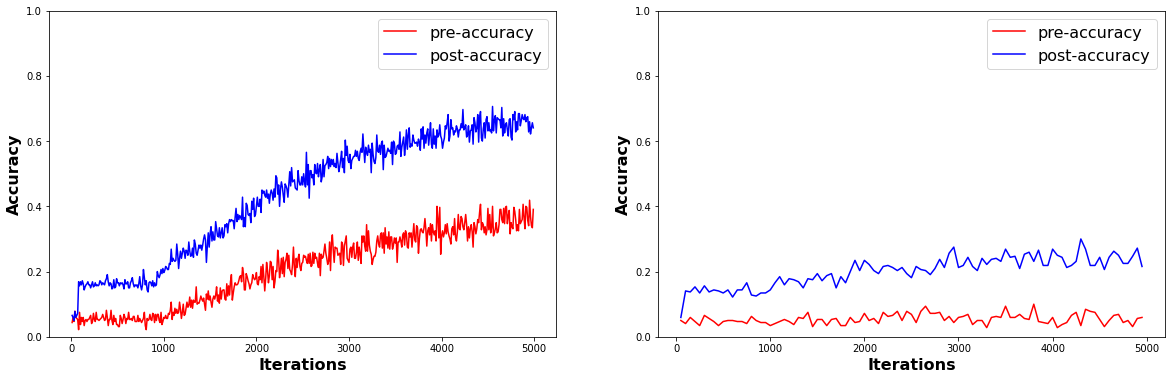

In [ ]:
import matplotlib.pyplot as plt

fig,(ax1, ax2) = plt.subplots(ncols=2,figsize=(20,6))

ax1.plot(step_train_trj,pre_train_accuracy_trj,label='pre-accuracy',c='r')
ax1.plot(step_train_trj,post_train_accuracy_trj,label='post-accuracy',c='b')

ax2.plot(step_num_trj,pre_val_accuracy_trj,label='pre-accuracy',c='r')
ax2.plot(step_num_trj,post_val_accuracy_trj,label='post-accuracy',c='b')

ax1.legend(fontsize=16)
ax2.legend(fontsize=16)
ax1.set_ylim(0.0,1.0)
ax2.set_ylim(0.0,1.0)
ax1.set_ylabel('Accuracy',weight='bold',fontsize=16)
ax1.set_xlabel('Iterations',weight='bold',fontsize=16)
ax2.set_ylabel('Accuracy',weight='bold',fontsize=16)
ax2.set_xlabel('Iterations',weight='bold',fontsize=16)
img_path = '{}/MAML-n_20-k-1_lr_0-4-memo.png'.format(result_path)
plt.savefig(img_path,dpi=300)
plt.show()

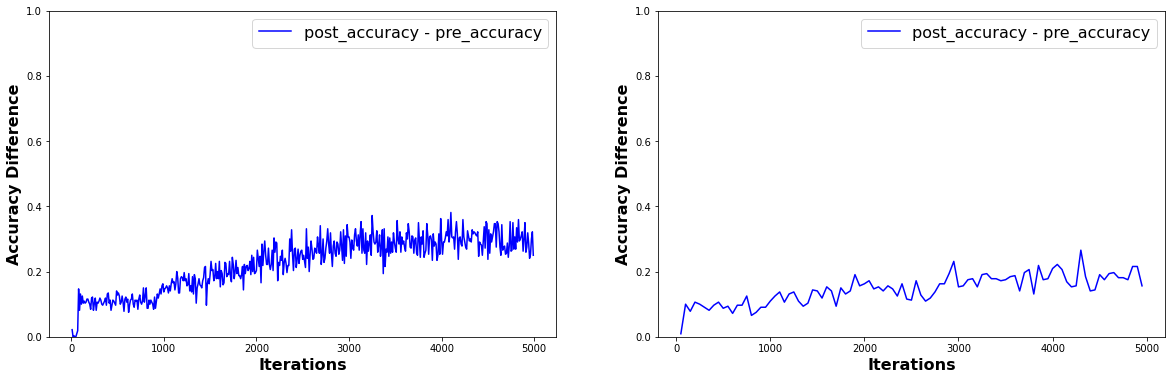

In [ ]:
fig,(ax1, ax2) = plt.subplots(ncols=2,figsize=(20,6))

ax1.plot(step_train_trj,np.asarray(post_train_accuracy_trj)-np.asarray(pre_train_accuracy_trj),label='post_accuracy - pre_accuracy',c='b')
ax2.plot(step_num_trj,np.asarray(post_val_accuracy_trj)-np.asarray(pre_val_accuracy_trj),label='post_accuracy - pre_accuracy',c='b')

ax1.legend(fontsize=16)
ax2.legend(fontsize=16)
ax1.set_ylim(0.0,1.0)
ax2.set_ylim(0.0,1.0)
ax1.set_ylabel('Accuracy Difference',weight='bold',fontsize=16)
ax1.set_xlabel('Iterations',weight='bold',fontsize=16)
ax2.set_ylabel('Accuracy Difference',weight='bold',fontsize=16)
ax2.set_xlabel('Iterations',weight='bold',fontsize=16)
img_path = '{}/MAML-n_20-k-1_lr_0-04-memo-diff.png'.format(result_path)
plt.savefig(img_path,dpi=300)
plt.show()

In [ ]:
means,stds,ci95=run_maml(n_way=20, k_shot=1, inner_update_lr=0.04, num_inner_updates=1,meta_train=False,meta_lr=0.0025,
                         meta_train_k_shot=1,logdir=log_path,train_type='memorization')

Number of training examples. :  1200
Number of validation examples:  100
Number of test examples      :  323
Training Type:  memorization
Restoring model weights from  /content/project_data/data/checkpoint/cls_20.mbs_25.k_shot_1.inner_numstep_1.inner_updatelr_0.04.learn_inner_update_lr_False.train_typememorization/model4999
Mean meta-test accuracy/loss, stddev, and confidence intervals
(0.165, 0.083765544, 0.006702639466786973)
pre accuracy stats
mean 0.04625 std 0.04670943
post accuracy stats
mean 0.165 std 0.083765544
